In [8]:
%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"

import torch
import torchopt
from einops import rearrange
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct

# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, masked_kspace, mask, csm


dataset = mri_data.SliceDataset(
    root=pathlib.Path("/Users/chunxuguo/ese5934_project/data"),
    transform=data_transform,
    challenge="multicoil",
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Grid Field (Voxel Representation)

In [5]:
from ese5934_project.models.GridField import Grid

field = Grid((640, 368))
optimizer = torchopt.adam(lr=0.001)
kspace, masked_kspace, mask, csm = dataset[15]

Done.


In [ ]:
print(masked_kspace.shape, mask.shape, csm.shape)

In [6]:
params, image_list = reconstruct(
    field,
    torch.rand(1, 2),
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=200,
    device=torch.device("mps"),
)

iteration 1, loss: 0.0011084506986662745
iteration 2, loss: 0.20276296138763428
iteration 3, loss: 0.013381535187363625
iteration 4, loss: 0.044270891696214676
iteration 5, loss: 0.11586011946201324
iteration 6, loss: 0.08364998549222946
iteration 7, loss: 0.021141286939382553
iteration 8, loss: 0.0014303281204774976
iteration 9, loss: 0.029668185859918594
iteration 10, loss: 0.05672051012516022
iteration 11, loss: 0.049642279744148254
iteration 12, loss: 0.021677490323781967
iteration 13, loss: 0.0024766603019088507
iteration 14, loss: 0.006339809857308865
iteration 15, loss: 0.022433355450630188
iteration 16, loss: 0.030351584777235985
iteration 17, loss: 0.022597357630729675
iteration 18, loss: 0.008582262322306633
iteration 19, loss: 0.0015756580978631973
iteration 20, loss: 0.005609204061329365
iteration 21, loss: 0.013487718068063259
iteration 22, loss: 0.015842515975236893
iteration 23, loss: 0.010701170191168785
iteration 24, loss: 0.0038123968988656998
iteration 25, loss: 0.00

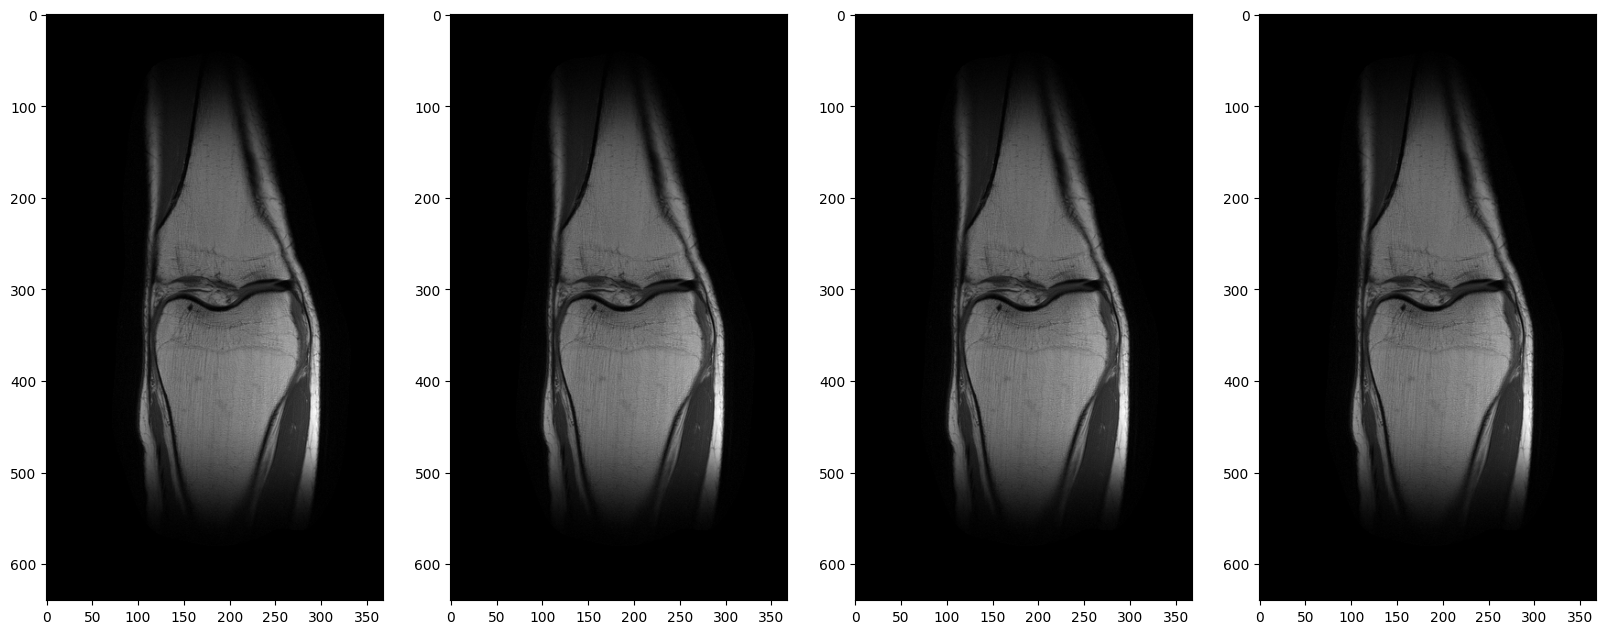

In [7]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")

# SIREN

In [9]:
from ese5934_project.models.SIREN import Siren, get_coordinates

size = (640, 368)
coords = get_coordinates(size)
field = Siren(
    size,
    in_features=2,
    out_features=2,
    hidden_features=256,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adam(lr=0.01)
kspace, masked_kspace, mask, csm = dataset[15]
device = torch.device("mps")

Done.


In [10]:
params, image_list = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=400,
    device=device,
)

iteration 1, loss: 453.20880126953125


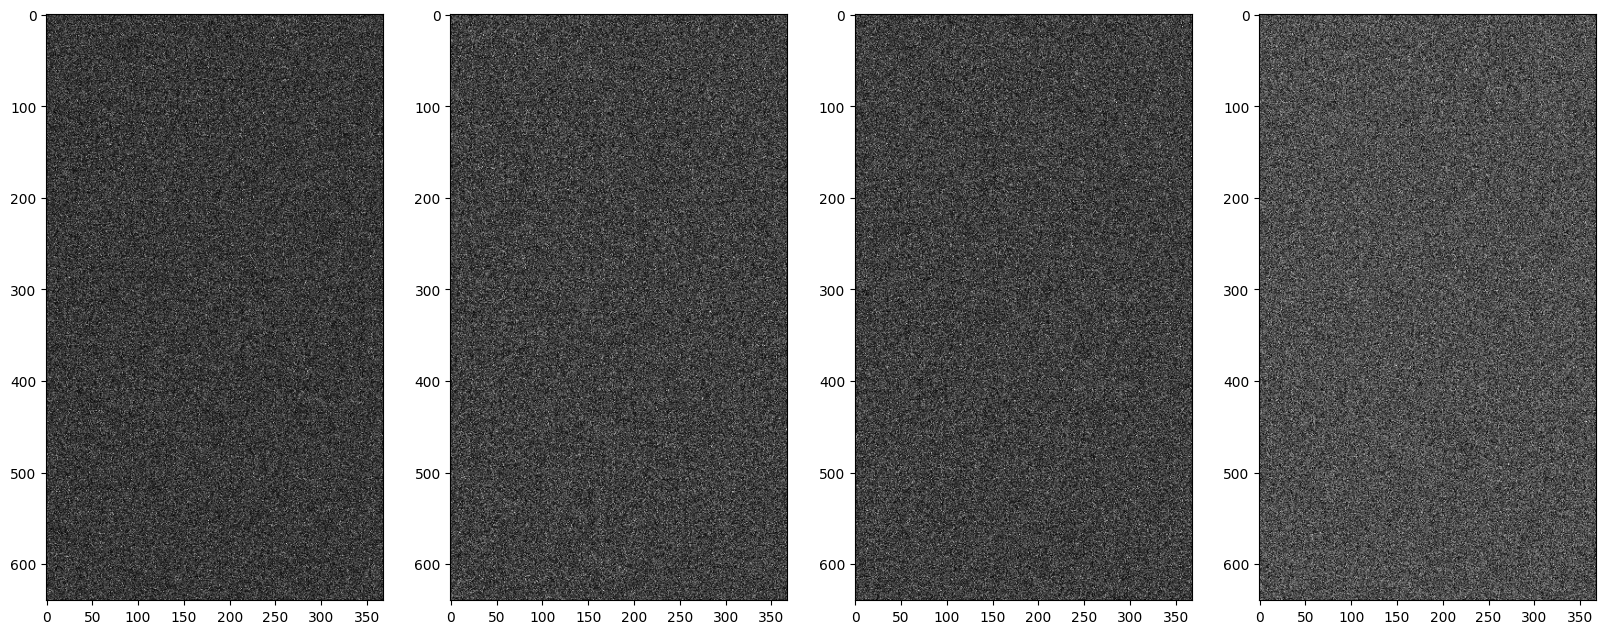

In [ ]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")